In [25]:
import numpy as np
import math
import random

In [26]:
def kernel(x,y):
    return math.exp((-(x-y)**2)/2)

In [27]:
def computeMMD(x,y,N):
    g = [[kernel(x[i], x[j]) + kernel(y[i],y[j]) - (2*kernel(x[i], y[j])) for j in range(N)] for i in range(N)]
    return math.sqrt((sum(map(sum,g)) / N**2))

In [28]:
def update(x,y,n):
    sum = 0
    for l in range(n):
        sum += kernel(x[l],x[n-1]) + kernel(y[l],y[n-1]) - (2*kernel(x[l],y[n-1]))
    for m in range(n-1):
        sum += kernel(x[n-1],x[m]) + kernel(y[n-1],y[m]) - (2*kernel(x[n-1],y[m]))
    return sum/(n**2)

In [29]:
###########     Algorithm 1 KMED-SEQ: Clustering when K is known S    #########

M = 12  # total no of streams
K = 2   # no of clusters
#Mk = 5  # no of streams per cluster
correct = [[0,1,2,3,4,5,6,7,8],[9,10,11]]
means = [0.4,0.55,0.7,0.85,1,1.15,1.3,1.45,1.6,1.85,2,2.15]

print(correct,means)

[[0, 1, 2, 3, 4, 5, 6, 7, 8], [9, 10, 11]] [0.4, 0.55, 0.7, 0.85, 1, 1.15, 1.3, 1.45, 1.6, 1.85, 2, 2.15]


In [30]:
import math
constvec = [1,1.1,1.2,1.3,1.4,1.5,1.6,1.7,1.8,1.9,2]
Pe = np.zeros(len(constvec))
lnPe=np.zeros(len(constvec))
expsamples=np.zeros(len(constvec))
print(Pe,lnPe,expsamples)

for ii in range(len(constvec)):
    const = constvec[ii]
    iter_sum = 0
    error = 0
    total = 0
    while error < 30:
        ##############  INITIALISATION  ################
        # cluster indices 0 to M-1 and an empty list lst
        clusters = [[i] for i in range(M)]
        lst = [[] for i in range(M)]

        # generate first 2 samples to initialize MMD estimate
        nn = 2
        X = np.asarray([np.random.normal(means[j],1,nn) for j in range(M)])

        ####    Calculating initial MMDs between each pair of sequences    ####

        lst_dseq =np.zeros((M,M))
        for i in range(1,M):
            for j in range(i):
                lst_dseq[i][j] = computeMMD(X[i,:],X[j,:],nn)
                lst_dseq[j][i] = lst_dseq[i][j]
        #print(lst_fixed)

        ##### TEST-STATISTIC Tn INITIALISATION #####
        Tn = 0
        #print(np.min(lst_index,axis = 0))               #it will a column matrix of all 0
        #print(np.min(lst_index,axis = 1))                #it will a row matrix of all 0

        #minval = np.min(lst_fixed[np.nonzero(lst_fixed)])         #will give you the non zero min value of the matrix
        #print(minval)

        #[min_i,min_j] = np.where(lst_fixed==minval)       #will give the index of the  min value of the matrix
        #print([min_i,min_j])

        #Tn = minval    #minimum inter-cluster distance
        #print('Minimum inter-cluster distance after iteration ', nn, ':', Tn)

        while Tn < (const/(nn**(1/3))):
            nn =nn + 1

            lst_dc = [[] for i in range(M)]
            lst_dc = [[lst_dseq[i][j] for j in range(i+1)] for i in range(M)]
            for i in range(M):
                for j in range(M):
                    if i<j:
                        lst_dc[i].append(lst_dc[j][i])
            #print(lst_new)
            #####
            # Code for SLINK
            clusters = [[i] for i in range(M)]
            # Merge closest clusters till number of clusters is equal to K
            while len(clusters)>K:

                ####    FIND MINIMUM    ####

                #mi = sys.float_info.max
                mi = 100
                for i in range(len(lst_dc)):
                    for j in range(i+1):
                        if i != j:
                            if lst_dc[i][j] < mi:
                                mi = lst_dc[i][j]
                                a,b = [i,j]
                #print("the values of a and b are :", a,b)
                clusters[b].extend(clusters[a])  #add the elements of a to b at the end
                del clusters[a]                   #delete cluster a
                #print(clusters)

                ####    MERGE ROWS  ####
                #print("the lst[b] is ",lst[b])
                #print("the lst[a] is ",lst[a])
                for i in range(len(lst_dc[b])):        #merge rows 'a' and 'b'
                    if min(lst_dc[a][i],lst_dc[b][i]) != 0:
                        lst_dc[b][i] = min(lst_dc[a][i],lst_dc[b][i])
                del lst_dc[a]

                ####    UPDATE ROWS     ####
                for i in range(len(lst_dc)):       #update all other rows
                    if i!=b:
                        lst_dc[i][b] = min(lst_dc[i][a],lst_dc[i][b])
                    del lst_dc[i][a]   #new statement

                #print('dist matrix', lst)
                #print('dist matrix 2', dist)
                #print('clusters',clusters)

            #print('Clusters after iteration ', nn, ':', clusters)

            mi = 100
            for i in range(len(lst_dc)):
                for j in range(i+1):
                    if i != j:
                        if lst_dc[i][j] < mi:
                            mi = lst_dc[i][j]
            Tn = mi

            # generate one more sample for each data stream
            z = np.asarray([np.random.normal(means[j],1,1) for j in range(M) ])  #creates a 1 dim array with means and SD 1
            X = np.append(X,z,axis=1)       # new samples   #axis =1 means it will add the values of z along column wise

            #Update MMDs between each pair of data streams
            lst_dseq_1=np.zeros((M,M))
            for i in range(M):
                for j in range(i):
                    lst_dseq_1[i,j] = math.sqrt(((lst_dseq[i][j]*(nn-1)/nn)**2) + update(X[i,:],X[j,:],nn))      # updated distances
                    lst_dseq_1[j,i]=lst_dseq_1[i,j]
            for i in range(M):
                for j in range(M):
                    lst_dseq[i,j] =lst_dseq_1[i,j]

        #print('Minimum inter-cluster distance after iteration ', nn, ':', Tn)
        #print('Clusters after iteration ', nn, ':', clusters)
        #print('Errors', error)
        #print('Total', total)

        # Check if clustering is correct and update errors and number of samples taken
        iter_sum += nn
        # CHECKING IF IT'S CORRECT
        clusters.sort()
        C_sort = []
        for x in clusters:
            x.sort()
            C_sort.append(x)

        if C_sort != correct:
            error = error + 1
        total = total + 1

        #print(C_sort)


    Pe[ii] = error/total
    lnPe[ii] = math.log(Pe[ii])
    expsamples[ii]= iter_sum/total
    print(lnPe[ii],expsamples[ii])

print(total,expsamples,lnPe)
print(iter_sum / total)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
-0.31237468504215243 147.4878048780488
-0.3364722366212129 465.57142857142856
-1.0761394328160512 908.1931818181819
-1.2901505005669882 1203.7064220183486
-2.5468376075184906 1808.7754569190602


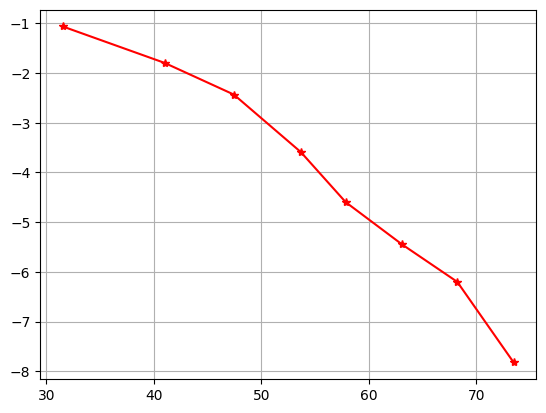

In [ ]:
import matplotlib.pyplot as plt
plt.grid()
plt.plot(expsamples,lnPe,"*r-")
x=[0.31578947,0.25423729,0.1056338,0.06396588,0.03807107]
y=[-1.15267951,-1.36948724,-2.24777686,-2.74940539,-3.26830071]


In [ ]:
print(lst)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


In [ ]:
a = [1,2,3,4,5]
b = a
a = [1,2]
print(a,b)

[1, 2] [1, 2, 3, 4, 5]


In [ ]:
print(lst)
print(lst_fixed)

[[], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], [], []]


NameError: name 'lst_fixed' is not defined

In [ ]:
x = -np.matrix(np.arange(12).reshape((3,4))); x
#matrix([[  0,  -1,  -2,  -3],
       # [ -4,  -5,  -6,  -7],
        #[ -8,  -9, -10, -11]])

print(x.min())
-11

print(x.min(0))
#matrix([[ -8,  -9, -10, -11]])

print(x.min(1))
#matrix([[ -3],
        #[ -7],
        #[-11]])

-11
[[ -8  -9 -10 -11]]
[[ -3]
 [ -7]
 [-11]]
